<a href="https://colab.research.google.com/github/dinasoltanit/masters-projects/blob/master/LBM_MixingLength_Cylinder_v05_Re1310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flow Past Cylinder With Variable Viscosity (for an isothermal fluid)

In [170]:
# Importing Libraries
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [1]:
# Flow Parameters
maxIter = 30000 # Total number of time iterations.
Re      = 1310  # Reynolds number.
T = 273 + 15 # Temperature for isothermal fluid

# Velocity in lattice units
uLB     = 0.08

# Calculate Mach
Cs = 0.577
Ma = uLB / Cs
if (Ma >= 0.3):
  print("Ma = " + str(Ma) + "Error!")
else:
  print(Ma)

0.15597920277296362


In [172]:
ny = 540
ly=ny-1.0
q = 9

# Coordinates of the cylinder
cy=ny/2
r=ny/9
print(r)

# nu in lattice units
nulb = uLB * r / Re
print(nulb)

# Lattice test dimention
#nx_test = ceil(nulb * Re / uLB)
#print(nx_test)

60.0
0.00366412213740458


In [173]:
nx = 520 * 2
cx = nx/4

In [174]:
# Calculate the Tau based on Prandtl's Mixing Length Turbulence Model
Dh = 2*r
Gammaa = 0.22
lmix = Gammaa * Dh # Mixing Length - Based on flow on flat plate
kappaa = 0.41 # Von-Karman Number
omega0 = 1.0 / (3.*nulb+0.5) # Relaxation parameter.
print(1/omega0)

0.5109923664122138


In [175]:
# Lattice Constants Definition
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)  
#t = 1./36. * ones(q, dtype=float128)                                   # Lattice weights.
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.
t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 
i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.

In [176]:
# Function Definition
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

def updateOmega (rho):
    # Update tau
    rho_avg = average(rho)
    Q = (kappaa * lmix)**2 / (2 * rho_avg * T**2)
    omega = (2*omega0) / (sqrt(1 + 4* Q* omega0**2) + 1)
    #print(1/omega)
    return omega

In [177]:
# Setup: cylindrical obstacle and velocity inlet with perturbation
obstacle = fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))
vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel); fin = feq.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

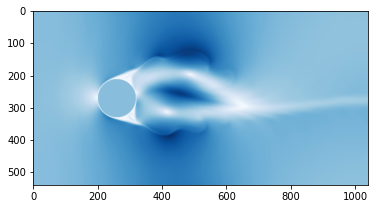

In [178]:
# Main Time Loop
for time in range(maxIter):
    fin[i1,-1,:] = fin[i1,-2,:] # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho

    u[:,0,:] =vel[:,0,:] # Left wall: compute density from known populations.
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    feq = equilibrium(rho,u) # Left wall: Zou/He boundary condition.
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    
    omega = updateOmega(rho)
    
    fout = fin - omega * (fin - feq)  # Collision step.
    for i in range(q): fout[i,obstacle] = fin[noslip[i],obstacle]
    for i in range(q): # Streaming step.
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    from google.colab import files
    if (time%3000==0): # Visualization
        plt.clf()
        plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.Blues)
        plt.savefig("Re1310_v1_vel."+str(time)+".png")
        files.download("Re1310_v1_vel."+str(time)+".png")